# Visualization

In [1]:
import zarr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
## Functions

def get_lengths(episode_ends, ep_start=0):
    start_inds = np.roll(episode_ends, 1)
    start_inds[0] = ep_start           # First trajectory starts from index 0
    ep_lens = episode_ends - start_inds
    return ep_lens, start_inds


def sample_and_visualize_trajectories(state, episode_ends, sample_size=100, precision=1., max_cnt=10, name_str=''):
    if len(name_str) > 0:
        name_str = ' (' + name_str + '; resol: ' + str(precision) + ')'
    
    # Step 1: Create arrays for start and end indices of each trajectory
    # start_indices = np.roll(episode_ends, 1)
    # start_indices[0] = 0  
    _, start_indices = get_lengths(episode_ends)
    end_indices = episode_ends

    # Step 2: Sample trajectories using their indices
    sampled_indices = np.random.choice(len(end_indices), min(len(end_indices), sample_size), replace=False)
    sampled_start_indices = start_indices[sampled_indices]
    sampled_end_indices = end_indices[sampled_indices]

    # Step 3: Visualize sampled trajectories
    plt.figure(figsize=(7, 7))
    for start_idx, end_idx in zip(sampled_start_indices, sampled_end_indices):
        trajectory = state[start_idx:end_idx, 2:5]  # Extract trajectory using indices
        plt.plot(trajectory[:, 0], trajectory[:, 1])
        # ## trajectory check for sudden jumps
        # for i in range(trajectory.shape[0]-1):
        #     if np.linalg.norm(trajectory[i+1, :2] - trajectory[i, :2]) > 19:
        #         print('trajectory error')
        #         print(trajectory[i+1, :2], trajectory[i, :2])
        #         break
    plt.title('Sampled Trajectories'+name_str)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, 512)
    plt.ylim(0, 512)
    plt.show()

    # Step 4: Create a heatmap
    # all_points = np.concatenate([state[start_idx:end_idx, 2:5] for start_idx, end_idx in zip(start_indices, end_indices)], axis=0)
    prob_density, xedges, yedges = np.histogram2d(
        state[:, 2], 
        state[:, 3], 
        bins=int(512 / precision), 
        range=[[0, 512], [0, 512]], 
        density=False
    )
    act_prob_density, act_xedges, act_yedges = np.histogram2d(
        state[:, 0], 
        state[:, 1], 
        bins=int(512 / precision), 
        range=[[0, 512], [0, 512]], 
        density=False
    )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    act_extent = [act_xedges[0], act_xedges[-1], act_yedges[0], act_yedges[-1]]
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max_cnt, clip=True)
    # heatmap *= 256  # Scale the heatmap to match the color range of the trajectories
    heatmap = norm(prob_density)
    act_heatmap = norm(act_prob_density)

    plt.figure(figsize=(7, 7))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='jet')
    plt.title('Heatmap of Trajectories'+name_str)
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.figure(figsize=(7, 7))
    plt.imshow(act_heatmap.T, extent=act_extent, origin='lower', cmap='jet')
    plt.title('Heatmap of Actions'+name_str)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.show()


In [3]:
## load dataset
data_root = zarr.open('data/pusht/pusht_cchi_v7_replay.zarr', mode='r')
pusht_state = np.array(data_root['data/state'])
pusht_episode_ends = np.array(data_root['meta/episode_ends'])

augmented_root = zarr.open('data/pusht/merged_pusht_cchi_v7_replay-seed_42r_33rf.zarr', mode='r')
augmented_state = np.array(augmented_root['data/state'])
augmented_episode_ends = np.array(augmented_root['meta/episode_ends'])

### basic statistics
pusht_ep_lens, _ = get_lengths(pusht_episode_ends)
augmented_ep_lens, _ = get_lengths(augmented_episode_ends)

### print basic info
print(f"PushT set:")
print(f"\tepisode count: {len(pusht_episode_ends)}")
print(f"\tEpisode length: {np.mean(pusht_ep_lens):.0f} +/- {np.std(pusht_ep_lens):.0f} (min: {np.min(pusht_ep_lens)}, max: {np.max(pusht_ep_lens)})")

print(f"Augmented set:")
print(f"\tepisode count: {len(augmented_episode_ends)}")
print(f"\taverage episode length: {np.mean(augmented_ep_lens):.0f} +/- {np.std(augmented_ep_lens):.0f} (min: {np.min(augmented_ep_lens)}, max: {np.max(augmented_ep_lens)})")


PushT set:
	episode count: 206
	Episode length: 125 +/- 36 (min: 49, max: 246)
Augmented set:
	episode count: 6686
	average episode length: 289 +/- 62 (min: 49, max: 447)


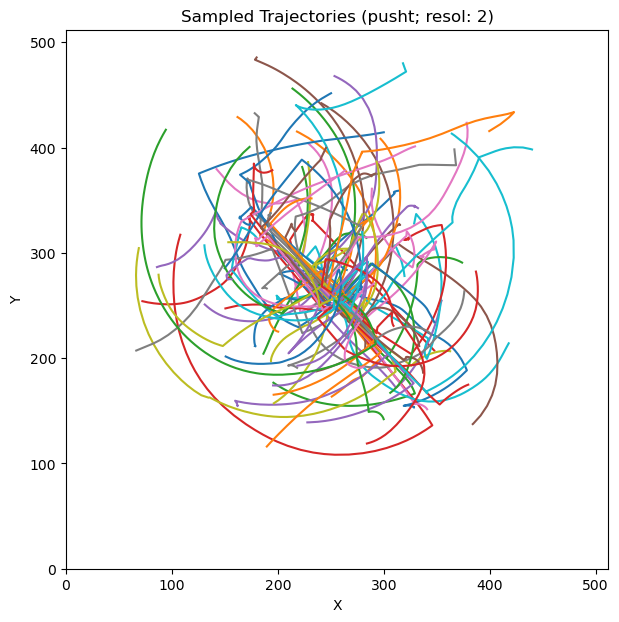

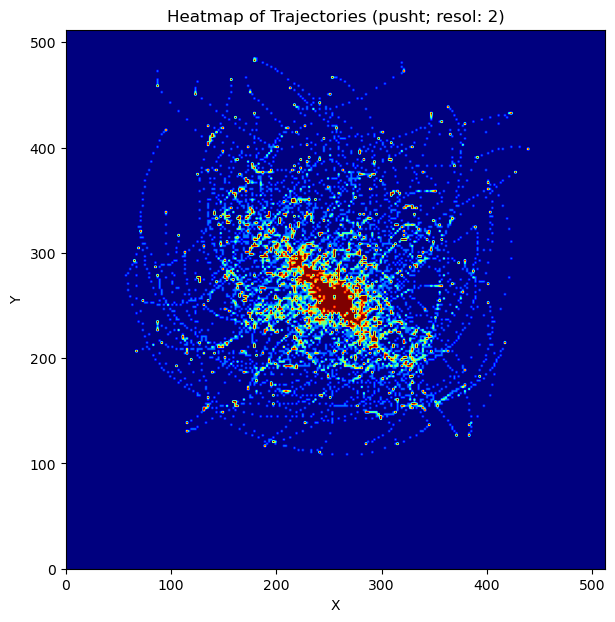

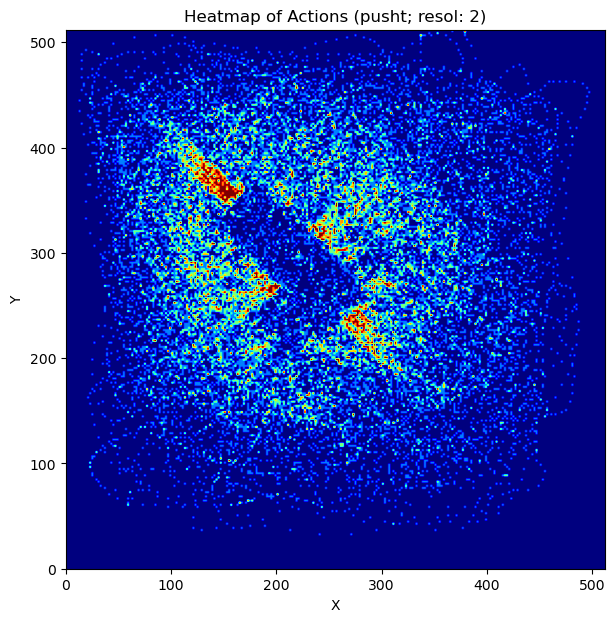

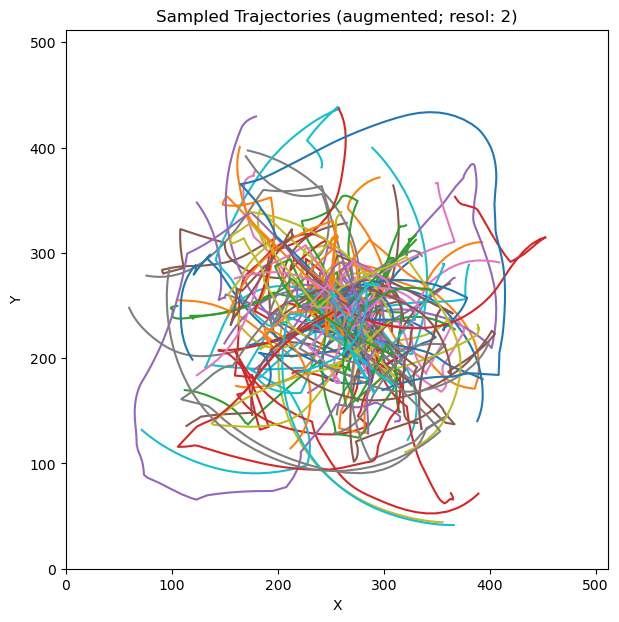

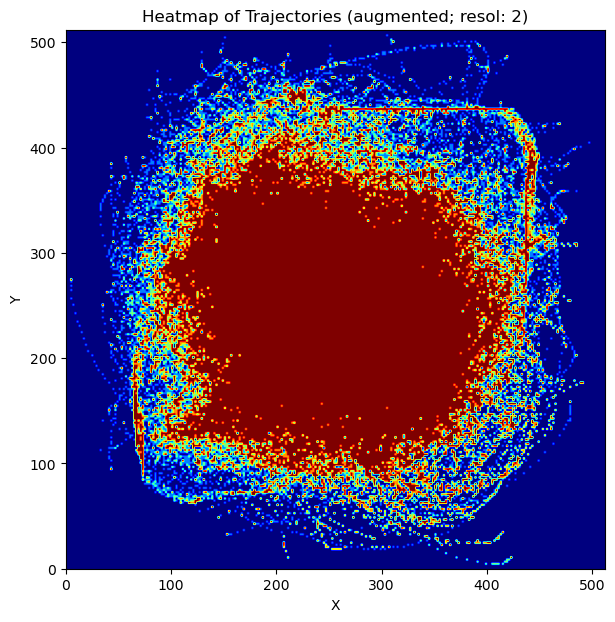

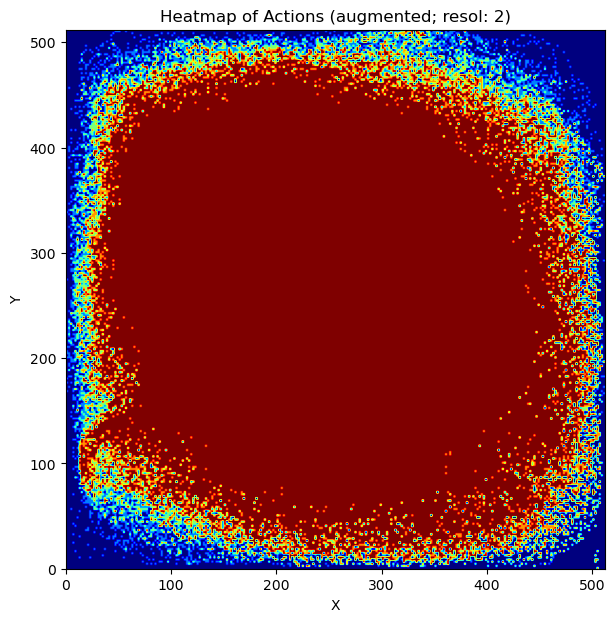

In [4]:
prec = 2
max_cnt = 4
samp_sz = 100
sample_and_visualize_trajectories(pusht_state, pusht_episode_ends, sample_size=samp_sz, precision=prec, max_cnt=max_cnt, name_str='pusht')
sample_and_visualize_trajectories(augmented_state, augmented_episode_ends, sample_size=samp_sz, precision=prec, max_cnt=max_cnt, name_str='augmented')


In [5]:
## Functions
import matplotlib.patches as patches

def plot_circles(state, traps, precision=1., max_cnt=10, name_str=''):
    if len(name_str) > 0:
        name_str = ' (' + name_str + '; resol: ' + str(precision) + ')'

    # Step 4: Create a heatmap
    # all_points = np.concatenate([state[start_idx:end_idx, 2:5] for start_idx, end_idx in zip(start_indices, end_indices)], axis=0)
    prob_density, xedges, yedges = np.histogram2d(
        state[:, 2], 
        state[:, 3], 
        bins=int(512 / precision), 
        range=[[0, 512], [0, 512]], 
        density=False
    )
    act_prob_density, act_xedges, act_yedges = np.histogram2d(
        state[:, 0], 
        state[:, 1], 
        bins=int(512 / precision), 
        range=[[0, 512], [0, 512]], 
        density=False
    )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    act_extent = [act_xedges[0], act_xedges[-1], act_yedges[0], act_yedges[-1]]
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max_cnt, clip=True)
    # heatmap *= 256  # Scale the heatmap to match the color range of the trajectories
    heatmap = norm(prob_density)
    act_heatmap = norm(act_prob_density)

    fig, ax = plt.subplots(figsize=(7, 7))
    circles = [patches.Circle((trap[0], trap[1]), trap[2], edgecolor='black', facecolor='none', linewidth=2) for trap in traps]

    # Clear the previous plot and add the modified circle
    ax.clear()
    for c in circles: 
        ax.add_patch(c)
    ax.set_aspect('equal')
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='jet')
    ax.set_title('Heatmap of Trajectories'+name_str)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()


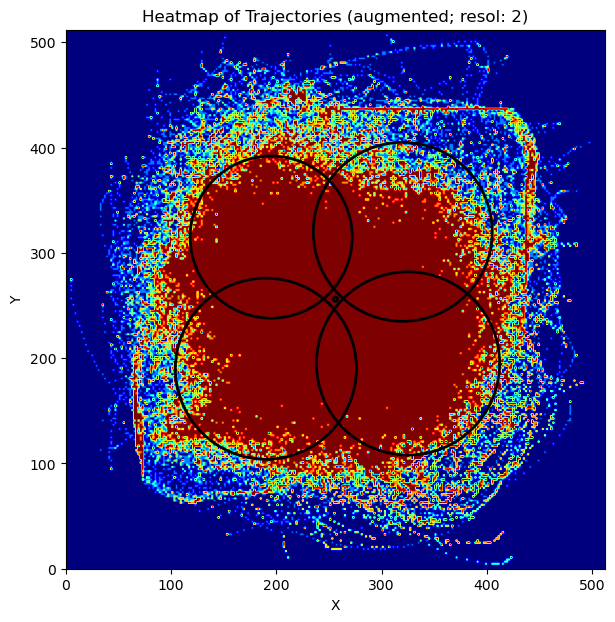

In [6]:
# Visualize regions
traps = np.array([
    [256, 256, 2], ## this is not a trap
    [190, 190, 86],
    [325, 195, 87],
    [320, 320, 85],
    [195, 315, 77],
])

plot_circles(augmented_state, traps=traps, precision=prec, max_cnt=4, name_str='augmented')